In [15]:
import math
from graphviz import Digraph
import matplotlib.pyplot as plt
import numpy as np
import random

In [16]:
class Value:
    """
    A class to represent a single scalar value,
    supporting basic arithmetic operations and automatic differentiation.
    """
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        """
        Perform backpropagation to calculate the gradient of the Value.
        """
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

class Neuron:
    """
    A class to represent a single neuron in a neural network.
    """
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi , xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    """
    A class to represent a layer of neurons in a neural network.
    """
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    """
    A class to represent a multi-layer perceptron (MLP) neural network.
    """
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [17]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


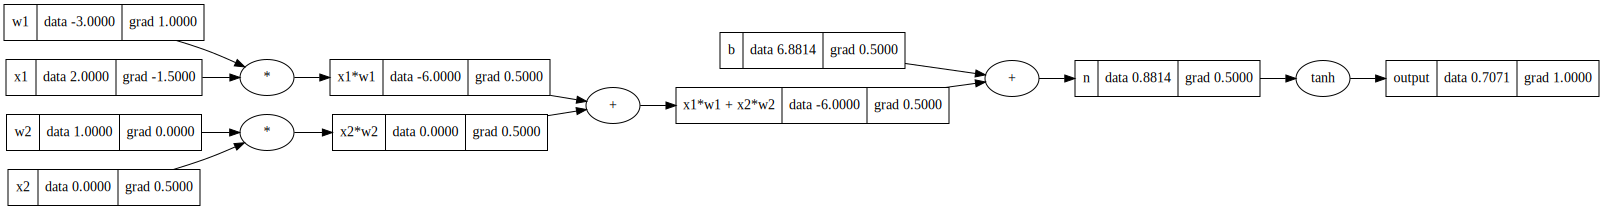

In [18]:
#input:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813725870195432, label='b')

#what happens inside a node
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh()
o.label = "output"

o.backward()

draw_dot(o)


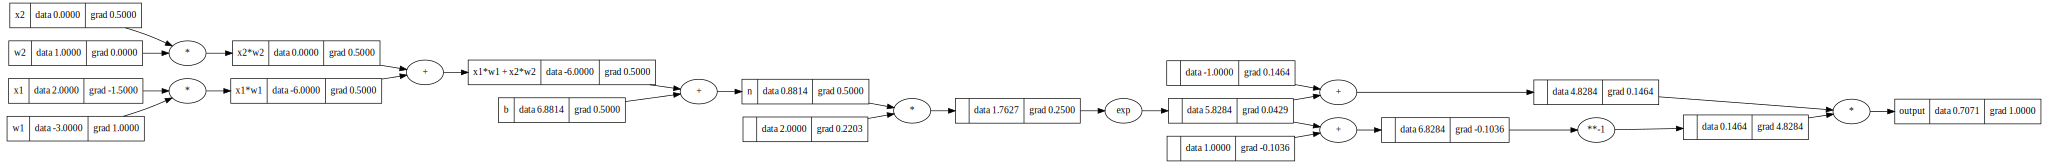

In [19]:
#input:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias
b = Value(6.8813725870195432, label='b')

#what happens inside a node
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# -------------------
e = (2 * n).exp()
o = (e - 1)/ (e + 1)
# -------------------
o.label = "output"

o.backward()

draw_dot(o)

In [20]:

x = [2.0, 3.0, -1.0]
n = MLP(3, [4 , 4, 1])
n(x)

xs = [
    [2.0, 3.0, -1.0],
    [3.0,-1.0,0.5],
    [0.5, 1, 1],
    [1,1,-1]

]
ys = [1,-1,-1,1]

In [21]:

for k in range(1000):
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))

  for p in n.parameters():
    p.grad = 0.0

  loss.backward()
  for p in n.parameters():
    p.data += -0.05 * p.grad

  if k % 20 == 0:
    print(k, loss.data)

0 6.555190037978582
20 0.03936462018789437
40 0.01589964186039599
60 0.009720294867849557
80 0.0069330790234559125
100 0.005361481903316857
120 0.004357798892140033
140 0.0036635215434001928
160 0.0031557761302944444
180 0.0027688838760881007
200 0.0024646323157024785
220 0.002219313351570643
240 0.0020174561336407074
260 0.0018485452041552609
280 0.0017051890272710307
300 0.001582043367091643
320 0.001475150363488688
340 0.0013815176253378651
360 0.0012988415948268516
380 0.0012253206886724895
400 0.0011595260170430845
420 0.0011003100219570744
440 0.0010467406825269393
460 0.000998053323799461
480 0.000953614776739998
500 0.0009128963528163067
520 0.0008754532071899581
540 0.0008409083978991165
560 0.0008089404416765711
580 0.0007792735044163192
600 0.0007516695986278045
620 0.0007259223252969243
640 0.0007018518154053885
660 0.0006793006114960423
680 0.00065813029188402
700 0.0006382186860565383
720 0.0006194575640675033
740 0.000601750708524305
760 0.0005850122973458207
780 0.00056

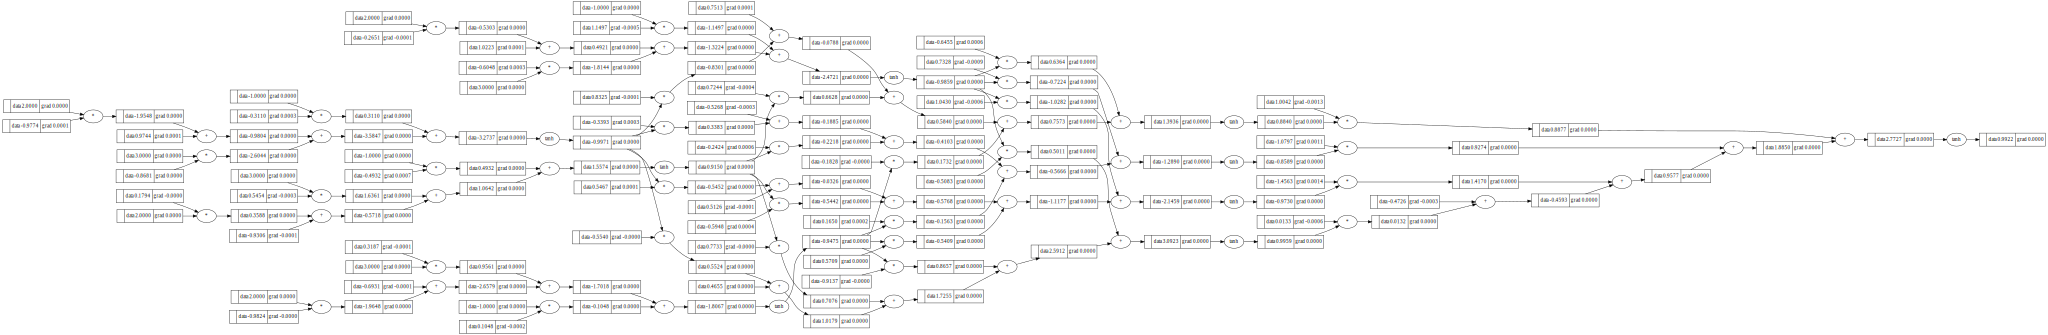

In [22]:
draw_dot(n(x))